In [1]:
###### %matplotlib inline
# %config InlineBackend.figure_format = 'retina'

# convolutional autoencoder in keras

import os
#os.environ["KERAS_BACKEND"] = "tensorflow"

from __future__ import print_function
from keras.models import Model
from keras.layers import *
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras import backend as K

import matplotlib.pyplot as plt
# %matplotlib inline

from keras.datasets import mnist 

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import nilearn
from nilearn import plotting

from PIL import Image

K.set_learning_phase(1)

### Create input

size=21

train_path = "/home/hoffmann/MRI/training_data/"
test_path = "/home/hoffmann/MRI/test_data/"

def loadbatches(path, size, select=True):

    batches_temp = []
    listing = os.listdir(path)
    
    allpositions=[]
    
    for file in listing:
        img = nilearn.image.load_img(path + file).get_fdata()
        x_cuts=int(len(img)/size)
        y_cuts=int(len(img[0])/size)
        z_cuts=int(len(img[0][0])/size)
        x_rest=len(img)%size
        y_rest=len(img[0])%size
        z_rest=len(img[0][0])%size
        
        pos=[]
        
        for i in range(int(x_cuts)):
            x1=size*i+int(x_rest/2)
            x2=x1+size
            for j in range(int(y_cuts)):
                y1=size*j+int(y_rest/2)
                y2=y1+size
                for k in range(int(z_cuts)):
                    z1=size*k+int(z_rest/2)
                    z2=z1+size
                    im_cut=img[x1:x2,y1:y2,z1:z2]
                    batches_temp.append(im_cut)
                    
                    pos.append(np.array([x1,y1,z1]))
        
        allpositions.append(pos)
    
    batches_temp=np.asarray(batches_temp)                
    maxval=max(batches_temp.flatten())
    minval=min(batches_temp.flatten())
    batches_temp=(batches_temp-minval)/(maxval-minval)
    
    batches=[]
    
    vip=[]
                    
    if select :                
        stdtrain=np.zeros((len(batches_temp)))
        for i in range(len(batches_temp)):
            stdtrain[i]=np.std(batches_temp[i].flatten())

        k=0
        medstd=np.percentile(stdtrain,99)
        for i in range(len(allpositions)):
            for j in range(len(allpositions[i])):
                if stdtrain[k]>medstd:
                    batches.append(batches_temp[k])
                    vip.append(np.array([i,j]))
                k=k+1
    
    else : batches = batches_temp
    
    batches=np.asarray(batches)
    
    shape=np.shape(batches)
    return batches.reshape(shape[0],shape[1],shape[2],shape[3],1),allpositions,vip

def show_skull(path, n=0):
    listing = os.listdir(test_path)
    img = nilearn.image.load_img(path + listing[n])
    plotting.plot_anat(img)

def show_batch(x_test, decoded_imgs=None, n=7):
    plt.figure(figsize=(20, 10))
    for i in range(n):
        ax = plt.subplot(6, n, i+1)
        plt.imshow(x_test[i][int(size/2)+1].reshape(size,size))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(6, n, i+1+n)
        plt.imshow(x_test[i][:,int(size/2)+1,:].reshape(size,size))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(6, n, i+1+2*n)
        plt.imshow(x_test[i][:,:,int(size/2)+1].reshape(size,size))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if decoded_imgs is not None:
            ax = plt.subplot(6, n, i+1+3*n)
            plt.imshow(decoded_imgs[i][int(size/2)+1].reshape(size,size))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            ax = plt.subplot(6, n, i+1+4*n)
            plt.imshow(decoded_imgs[i][:,int(size/2)+1,:].reshape(size,size))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        
            ax = plt.subplot(6, n, i+1+5*n)
            plt.imshow(decoded_imgs[i][:,:,int(size/2)+1].reshape(size,size))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()
    
    
def show_hidden(x_test, encoded_imgs, n1, n=10):

    plt.figure(figsize=(20, 10))
    for i in range(n):
        ax = plt.subplot(3*(n1+1), n, i+1)
        plt.imshow(x_test[i][int(size/2)+1].reshape(size,size))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3*(n1+1), n, i+1+n)
        plt.imshow(x_test[i][:,int(size/2)+1,:].reshape(size,size))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3*(n1+1), n, i+1+2*n)
        plt.imshow(x_test[i][:,:,int(size/2)+1].reshape(size,size))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        if encoded_imgs is not None:
            for j in range(n1):
                ax = plt.subplot(3*(n1+1), n, i+1+(3+3*j)*n)
                plt.imshow(encoded_imgs[i][int(size/6)+1,:,:,j].reshape(int(size/3),int(size/3)))
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
        
                ax = plt.subplot(3*(n1+1), n, i+1+(4+3*j)*n)
                plt.imshow(encoded_imgs[i][:,int(size/6)+1,:,j].reshape(int(size/3),int(size/3)))
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
        
                ax = plt.subplot(3*(n1+1), n, i+1+(5+3*j)*n)
                plt.imshow(encoded_imgs[i][:,:,int(size/6)+1,j].reshape(int(size/3),int(size/3)))
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
            
    plt.show()

def getMaxGrads(input_set, model, layer_name, nof):
    
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    
    out = np.zeros((len(input_set),len(input_set[0]),len(input_set[0][0]),len(input_set[0][0][0])))

    for i in range(nof):
        filter_index = i

        layer_output = layer_dict[layer_name].output
        loss = K.mean(layer_output[:, :, :, :, filter_index])

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]

        #normalization trick: we normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)  ### normalize? ... later

        # this function returns the loss and grads given the input picture
        iterate = K.function([input_img], [loss, grads])

        it = iterate([input_set])
        
        len1=len(out)
        len2=len(out[0])
        len3=len(out[0][0])
        len3=len(out[0][0][0])
        
        for j in range(len1):
            for k in range(len2):
                for l in range(len3):
                    for m in range(len3):
                        if np.mean(abs(it[1][j][k][l][m])) > out[j][k][l][m]:   #abs()?
                        #if np.mean(it[1][j][k][l]) > out[j][k][l]:   #abs()?
                            out[j][k][l]=np.mean(it[1][j][k][l])
                        
    return out

/home/hoffmann/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(14, 256, 256, 256) (14, 256, 256, 256)


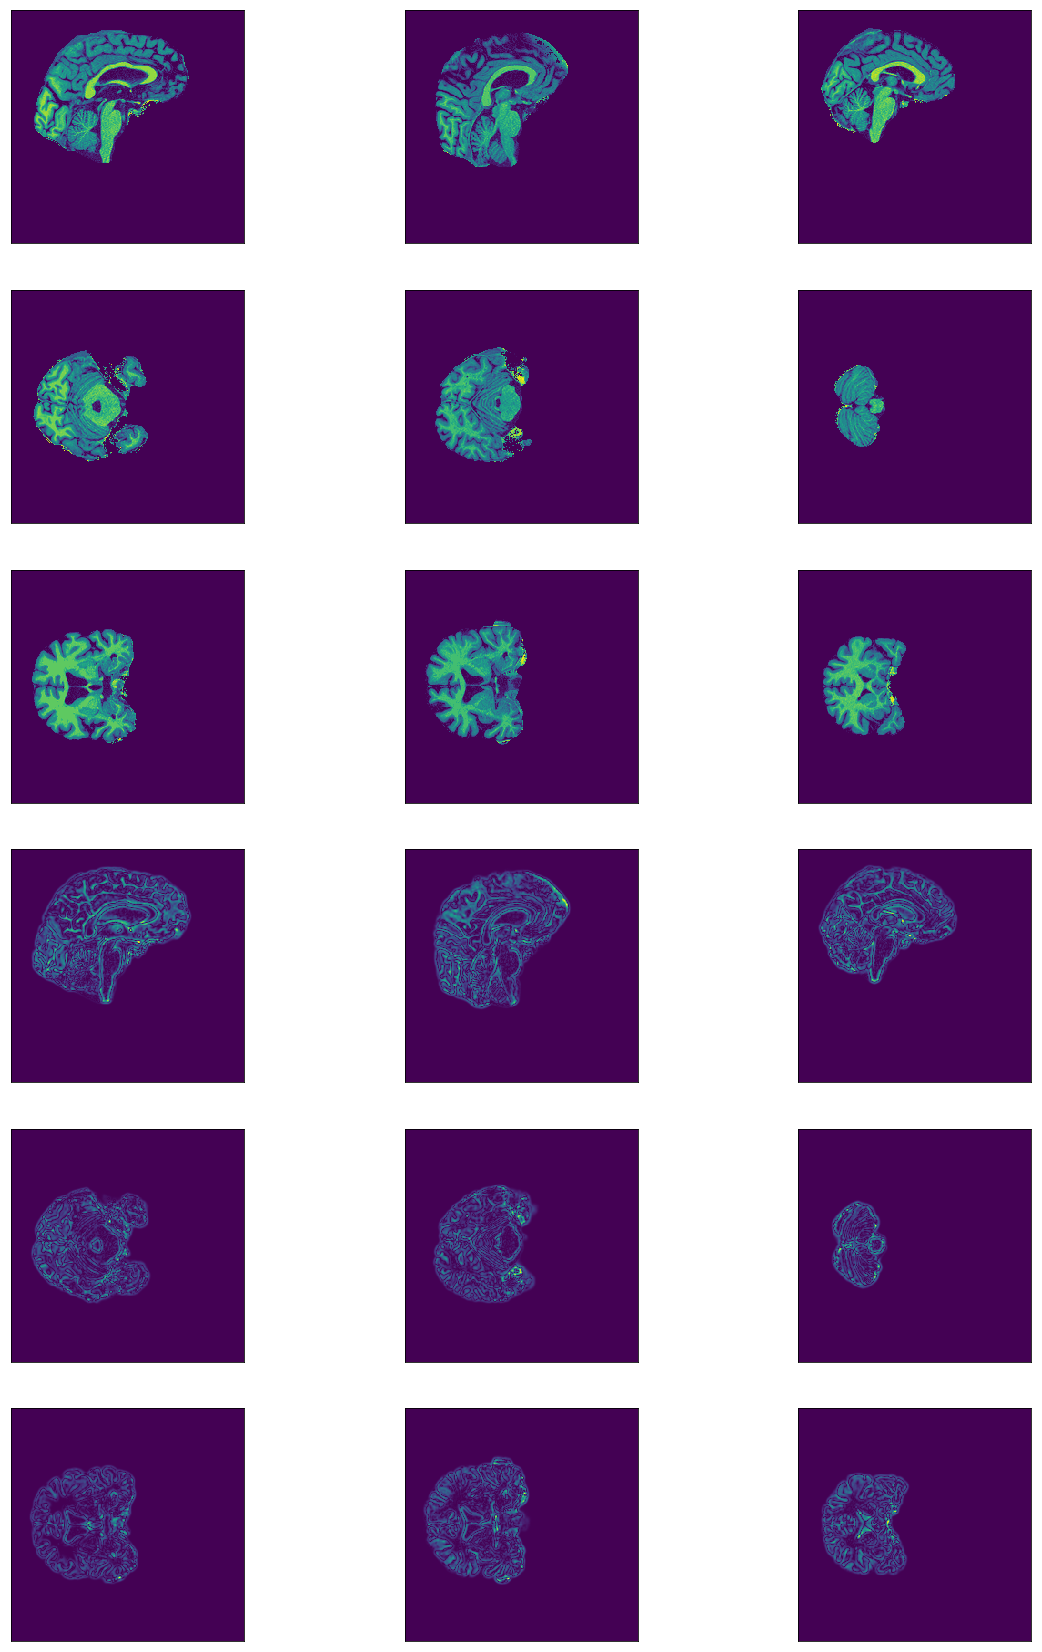

In [25]:
from scipy.ndimage.filters import gaussian_laplace

listing = os.listdir(test_path)

img = []
log = []

for file in listing:    
    img.append(nilearn.image.load_img(test_path + file).get_fdata())
    
img=np.asarray(img)                
maxval=max(img.flatten())
minval=min(img.flatten())
img=(img-minval)/(maxval-minval)

for i in range(np.shape(img)[0]):
    log.append(np.absolute(gaussian_laplace(img[i],1)))
    
log=np.asarray(log)                
maxval=max(log.flatten())
minval=min(log.flatten())
log=(log-minval)/(maxval-minval) 

print(np.shape(img),np.shape(log))

def show_whole(x_test, decoded_imgs=None, n=3):
    plt.figure(figsize=(20, 30))
    for i in range(n):
        ax = plt.subplot(6, n, i+1)
        plt.imshow(x_test[i][int(np.shape(x_test[i])[0]/2)+1])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(6, n, i+1+n)
        plt.imshow(x_test[i][:,int(np.shape(x_test[i])[1]/2)+1,:])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(6, n, i+1+2*n)
        plt.imshow(x_test[i][:,:,int(np.shape(x_test[i])[2]/2)+1])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if decoded_imgs is not None:
            ax = plt.subplot(6, n, i+1+3*n)
            plt.imshow(decoded_imgs[i][int(np.shape(x_test[i])[0]/2)+1])
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            ax = plt.subplot(6, n, i+1+4*n)
            plt.imshow(decoded_imgs[i][:,int(np.shape(x_test[i])[1]/2)+1,:])
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        
            ax = plt.subplot(6, n, i+1+5*n)
            plt.imshow(decoded_imgs[i][:,:,int(np.shape(x_test[i])[2]/2)+1])
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()
    
show_whole(img,log)

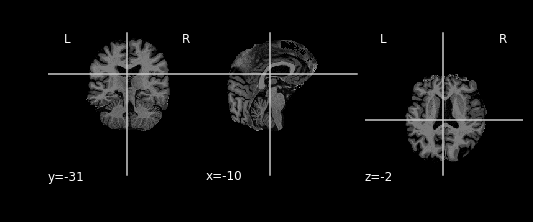

In [26]:
train_batches, train_allpos, train_vip=loadbatches(test_path, size)
test_batches, test_allpos, test_vip=loadbatches(test_path, size)

show_skull(test_path,1)

Train on 242 samples, validate on 242 samples
Epoch 1/10
242/242 [==============================] - 29s 118ms/step - loss: 0.0306 - val_loss: 0.0119
Epoch 2/10
242/242 [==============================] - 28s 116ms/step - loss: 0.0121 - val_loss: 0.0124
Epoch 3/10
242/242 [==============================] - 28s 116ms/step - loss: 0.0115 - val_loss: 0.0101
Epoch 4/10
242/242 [==============================] - 28s 116ms/step - loss: 0.0112 - val_loss: 0.0094
Epoch 5/10
242/242 [==============================] - 28s 116ms/step - loss: 0.0102 - val_loss: 0.0092
Epoch 6/10
242/242 [==============================] - 28s 117ms/step - loss: 0.0094 - val_loss: 0.0101
Epoch 7/10
242/242 [==============================] - 28s 116ms/step - loss: 0.0094 - val_loss: 0.0090
Epoch 8/10
242/242 [==============================] - 28s 116ms/step - loss: 0.0088 - val_loss: 0.0080
Epoch 9/10
242/242 [==============================] - 28s 116ms/step - loss: 0.0087 - val_loss: 0.0067
Epoch 10/10
242/242 [======

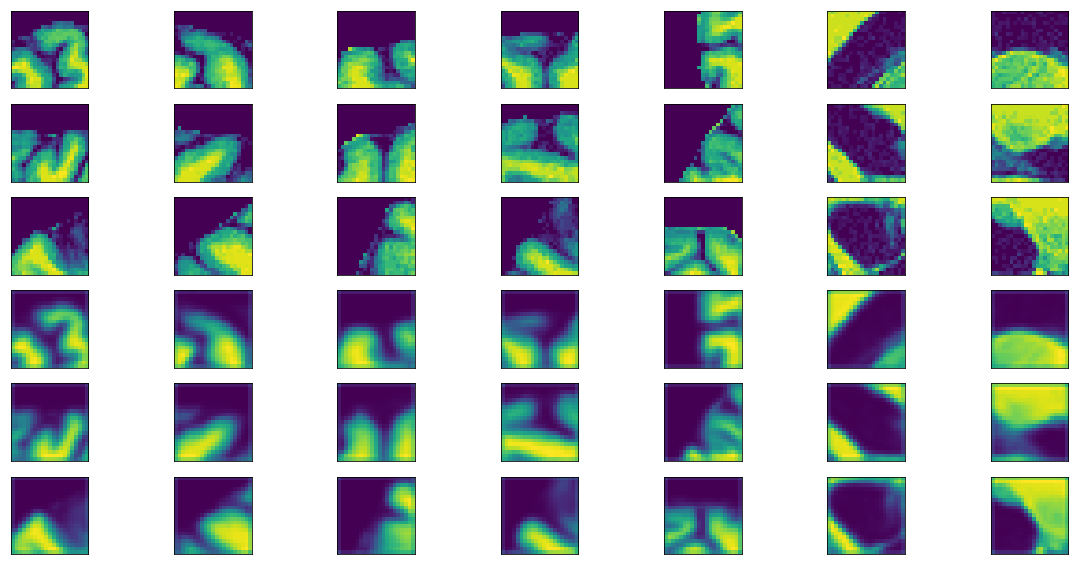

(242, 21, 21, 21, 32)
Epoch 1/10
242/242 [==============================] - 45s 188ms/step - loss: 0.0067
Epoch 2/10
242/242 [==============================] - 45s 187ms/step - loss: 0.0012
Epoch 3/10
242/242 [==============================] - 46s 190ms/step - loss: 6.7608e-04
Epoch 4/10
242/242 [==============================] - 45s 188ms/step - loss: 5.9563e-04
Epoch 5/10
242/242 [==============================] - 46s 190ms/step - loss: 5.4851e-04
Epoch 6/10
242/242 [==============================] - 46s 188ms/step - loss: 5.1406e-04
Epoch 7/10
242/242 [==============================] - 45s 188ms/step - loss: 4.8623e-04
Epoch 8/10
242/242 [==============================] - 46s 189ms/step - loss: 4.6308e-04
Epoch 9/10
242/242 [==============================] - 45s 188ms/step - loss: 4.4376e-04
Epoch 10/10
242/242 [==============================] - 46s 189ms/step - loss: 4.2801e-04
(242, 21, 21, 21, 32)
Epoch 1/10
242/242 [==============================] - 35s 146ms/step - loss: 0.0076

In [5]:
maxfil=32
bs_z=2
eps=10

### pretrain1
    
input_img = Input(shape=(size, size,size,1), dtype='float64')

train1_c1=Conv3D(maxfil, (3, 3, 3), activation='sigmoid', padding='same', name='t1c1')(input_img)
train1_decoded=Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same', name='t1tc1')(train1_c1)
#train1_decoded=Conv3DTranspose(1, (3, 3, 3), activation='sigmoid', padding='same', name='t1tc1')(train1_c1)

train1_autoencoder = Model(input_img, train1_decoded)
train1_autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

train1_autoencoder.fit(train_batches, train_batches, 
                       validation_data=(test_batches, test_batches),
                       epochs=eps, batch_size=bs_z, verbose=1)

show_batch(test_batches,train1_autoencoder.predict(test_batches))

### pretrain2

creator_train2 = Model(input_img, train1_c1)
creator_train2.get_layer("t1c1").set_weights(train1_autoencoder.get_layer('t1c1').get_weights())

input_train2 = creator_train2.predict(train_batches)

print(input_train2.shape)

#---

input_img_train2=Input(shape=(size, size, size, maxfil))
train2_c1=Conv3D(maxfil, (3, 3, 3), activation='sigmoid', padding='same', name='t2c1')(input_img_train2)
train2_decoded=Conv3D(maxfil, (3, 3, 3), activation='sigmoid', padding='same', name='t2tc1')(train2_c1)

train2_autoencoder = Model(input_img_train2, train2_decoded)
train2_autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

train2_autoencoder.fit(input_train2, input_train2, epochs=eps, batch_size=bs_z, verbose=1)


### pretrain3

creator_train3 = Model(input_img_train2, train2_c1)
creator_train3.get_layer("t2c1").set_weights(train2_autoencoder.get_layer('t2c1').get_weights())

input_train3 = creator_train3.predict(input_train2)

print(input_train3.shape)

#---

input_img_train3=Input(shape=(size, size, size, maxfil))
train3_c1=Conv3D(int(maxfil/2), (3, 3, 3), activation='sigmoid', padding='same', name='t3c1')(input_img_train3)
train3_decoded=Conv3D(maxfil, (3, 3, 3), activation='sigmoid', padding='same', name='t3tc1')(train3_c1)

train3_autoencoder = Model(input_img_train3, train3_decoded)
train3_autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

train3_autoencoder.fit(input_train3, input_train3, epochs=eps, batch_size=bs_z, verbose=1)

### pretrain4

creator_train4 = Model(input_img_train3, train3_c1)
creator_train4.get_layer("t3c1").set_weights(train3_autoencoder.get_layer('t3c1').get_weights())

input_train4 = creator_train4.predict(input_train3)

print(input_train4.shape)

#---

input_img_train4=Input(shape=(size, size, size, int(maxfil/2)))
train4_p1=MaxPooling3D(pool_size=(3, 3, 3), name='t4p1')(input_img_train4)
train4_c1=Conv3D(int(maxfil/4), (3, 3, 3), activation='sigmoid', padding='same', name='t4c1')(train4_p1)
train4_tc1=Conv3D(int(maxfil/2), (3, 3, 3), activation='sigmoid', padding='same', name='t4tc1')(train4_c1)
train4_decoded=UpSampling3D(size=(3, 3, 3), name='t4u1')(train4_tc1)

train4_autoencoder = Model(input_img_train4, train4_decoded)
train4_autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

train4_autoencoder.fit(input_train4, input_train4, epochs=eps, batch_size=bs_z, verbose=1)

Train on 242 samples, validate on 242 samples
Epoch 1/10
242/242 [==============================] - 140s 579ms/step - loss: 0.0388 - val_loss: 0.0322
Epoch 2/10
242/242 [==============================] - 139s 576ms/step - loss: 0.0295 - val_loss: 0.0354
Epoch 3/10
242/242 [==============================] - 139s 576ms/step - loss: 0.0278 - val_loss: 0.0266
Epoch 4/10
242/242 [==============================] - 139s 575ms/step - loss: 0.0255 - val_loss: 0.0233
Epoch 5/10
242/242 [==============================] - 140s 577ms/step - loss: 0.0248 - val_loss: 0.0217
Epoch 6/10
242/242 [==============================] - 139s 576ms/step - loss: 0.0229 - val_loss: 0.0220
Epoch 7/10
242/242 [==============================] - 140s 577ms/step - loss: 0.0216 - val_loss: 0.0223
Epoch 8/10
242/242 [==============================] - 140s 579ms/step - loss: 0.0204 - val_loss: 0.0192
Epoch 9/10
242/242 [==============================] - 140s 579ms/step - loss: 0.0197 - val_loss: 0.0197
Epoch 10/10
242/24

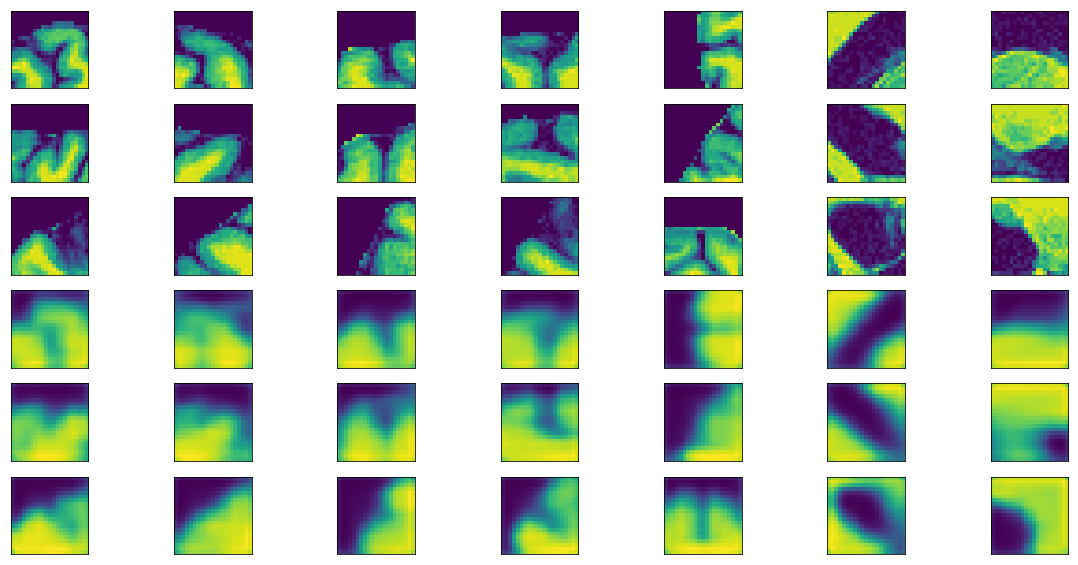

In [6]:
### unroll

input_img = Input(shape=(size, size, size,1))

c1 = Conv3D(maxfil, (3, 3, 3), activation='sigmoid', padding='same', name='c1', weights=train1_autoencoder.get_layer("t1c1").get_weights())(input_img)
c2 = Conv3D(maxfil, (3, 3, 3), activation='sigmoid', padding='same', name='c2', weights=train2_autoencoder.get_layer("t2c1").get_weights())(c1)
c3 = Conv3D(int(maxfil/2), (3, 3, 3), activation='sigmoid', padding='same', name='c3', weights=train3_autoencoder.get_layer("t3c1").get_weights())(c2)
p3 = MaxPooling3D(pool_size=(3, 3, 3), name='p3')(c3)
encoded = Conv3D(int(maxfil/4), (3, 3, 3), activation='sigmoid', padding='same', name='encoded', weights=train4_autoencoder.get_layer("t4c1").get_weights())(p3)
tc4 = Conv3D(int(maxfil/2), (3, 3, 3), activation='sigmoid', padding='same', name='tc4', weights=train4_autoencoder.get_layer("t4tc1").get_weights())(encoded)
u3 = UpSampling3D(size=(3, 3, 3), name='u3')(tc4)
tc3 = Conv3D(maxfil, (3, 3, 3), activation='sigmoid', padding='same', name='tc3', weights=train3_autoencoder.get_layer("t3tc1").get_weights())(u3)
tc2 = Conv3D(maxfil, (3, 3, 3), activation='sigmoid', padding='same', name='tc2', weights=train2_autoencoder.get_layer("t2tc1").get_weights())(tc3)
decoded = Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same', name='tc1', weights=train1_autoencoder.get_layer("t1tc1").get_weights())(tc2)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

### finetune

autoencoder.fit(train_batches, train_batches, epochs=eps, validation_data=(test_batches, test_batches), batch_size=bs_z, verbose=1)

show_batch(test_batches,autoencoder.predict(test_batches))

(242, 7, 7, 7, 8)


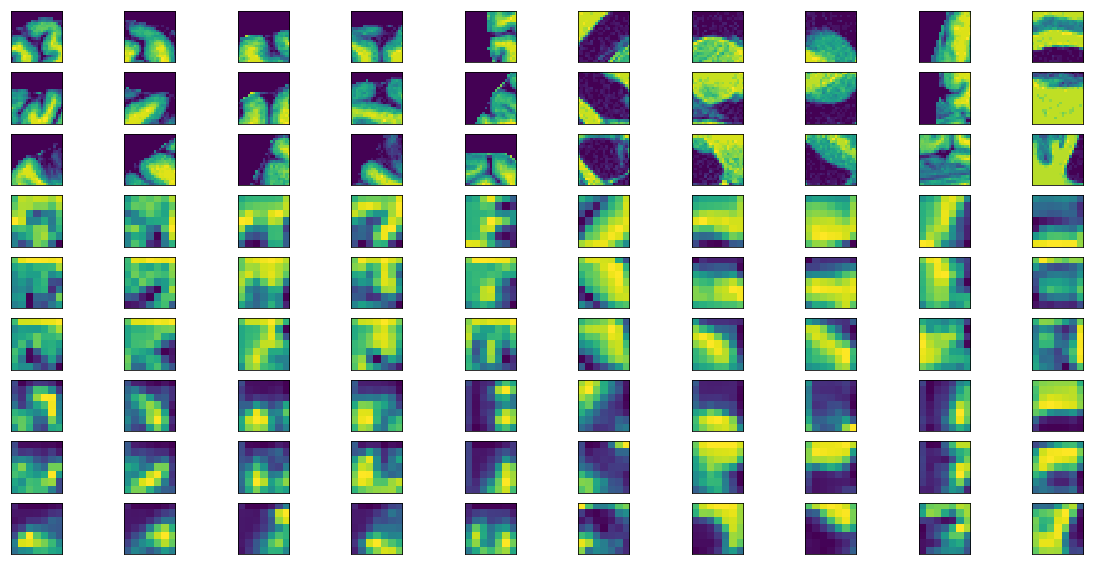

In [7]:
autoencoder_show_hidden = Model(input_img, encoded)
encoded_imgs = autoencoder_show_hidden.predict(test_batches)

print(np.shape(encoded_imgs))

show_hidden(test_batches, encoded_imgs, 2)

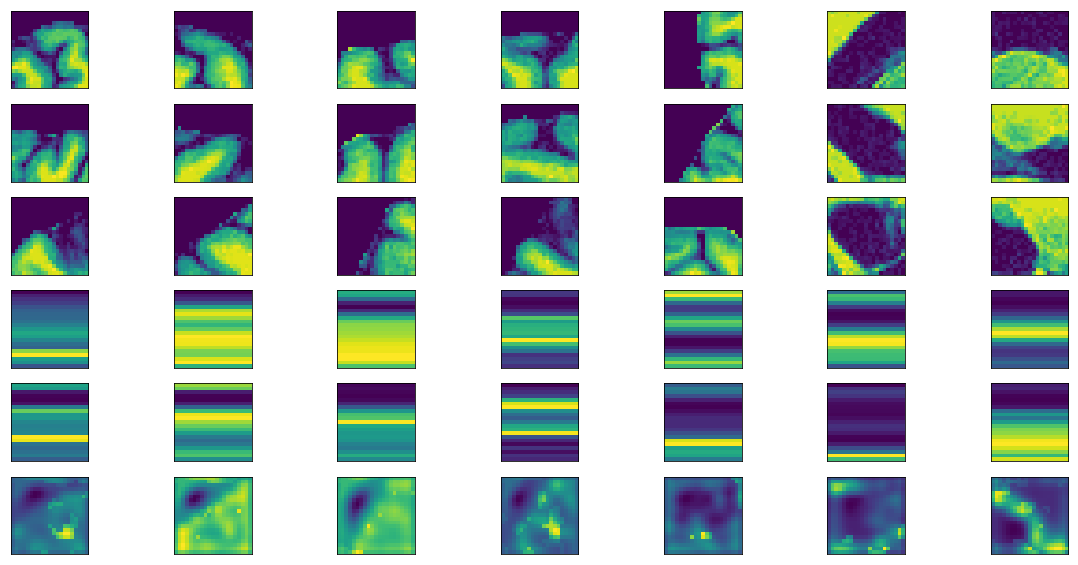

In [8]:
out = getMaxGrads(test_batches, autoencoder, 'encoded',int(maxfil/4))
show_batch(test_batches,out)

242 21 21 21


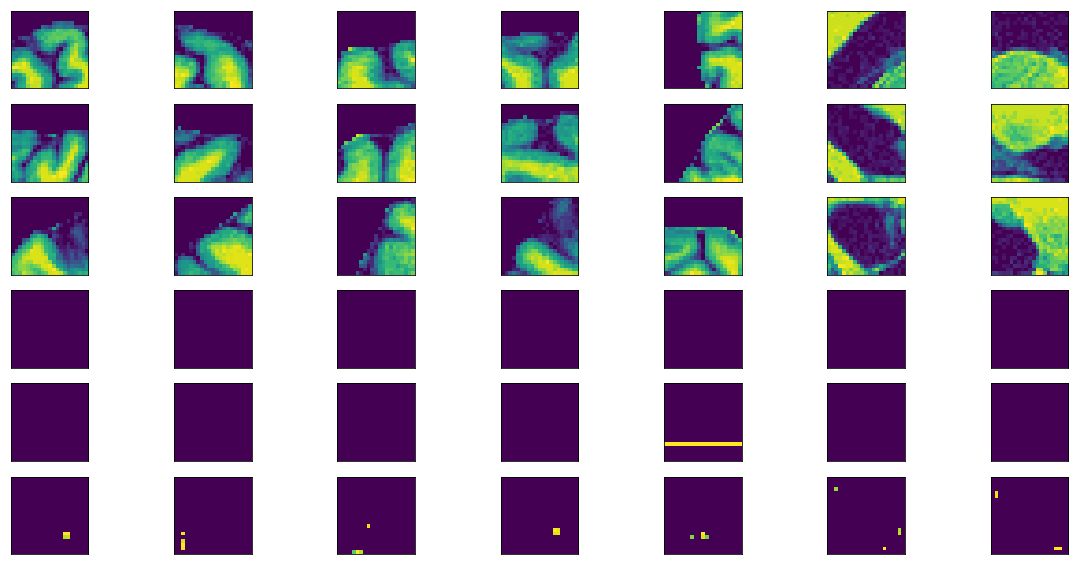

In [9]:
a=len(test_batches)
b=len(test_batches[0])
c=len(test_batches[0][0])
d=len(test_batches[0][0][0])
print(a,b,c,d)

it_temp = np.zeros((a,b,c,d))

for i in range(a):
    q = np.percentile(out[i],99)
    for j in range(b):
        for k in range(c):
            for l in range(d):
                if(out[i][j][k][l]>q):
                    it_temp[i][j][k][l]=out[i][j][k][l]
                    
show_batch(test_batches,it_temp)

In [80]:
init=0.000001

mean_act=[]
mean_act.append(np.full((maxfil),init))
mean_act.append(np.full(1,init))
mean_act.append(np.full((int(maxfil/2)),init))
mean_act.append(np.full((int(maxfil/4)),init))
mean_act.append(np.full((int(maxfil/4)),init))
mean_act.append(np.full((int(maxfil/2)),init))
mean_act.append(np.full((maxfil),init))
mean_act.append(np.full(1,init))

i = -1
j = -1

from keras import regularizers

def calc_mean(a_tensor):
    global i
    global j
    global mean_act
    
    if j == 1:
        j=-1
    
    j+=1
    i+=1
    
    ### x is 21x21x21xnof tensor -> combine to nof tensor (mean of all 21x21x21 activations?)
    
    #x=K.eval(a_tensor)
      
    for k in range(K.int_shape(a_tensor)[-1]):
        mean_act[j][k]=mean_act[j][k]*i/(i+1)+K.mean(a_tensor[:,:,:,:,k])
    return mean_act[j]

def kl_divergence(p, p_hat):
    return (p * K.log(p/p_hat)) + ((1-p) * K.log((1-p)/(1-p_hat)))

def kl_reg(x):
    beta=0.1
    p=0.001
    p_hat=calc_mean(x)
    res=0
    for i in range(len(K.int_shape(p_hat))):
        res+=kl_divergence(p,p_hat[i])
    
    return beta * res / K.int_shape(p_hat)

test2_c1=Conv3D(maxfil, (3, 3, 3), activation='sigmoid', padding='same', name='t1c1', activity_regularizer=kl_reg)(input_img)
test2_decoded=Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same', name='t1tc1', activity_regularizer=kl_reg)(test2_c1)
    
test2_autoencoder = Model(input_img, test2_decoded)
test2_autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

test2_autoencoder.fit(train_batches, train_batches, 
                     validation_data=(test_batches, test_batches),
                     epochs=2, batch_size=bs_z, verbose=1)

ValueError: setting an array element with a sequence.

In [78]:
print(mean_act[0])

[1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06
 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06
 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06
 1.e-06 1.e-06]


In [94]:
init=0.000001

mean_act=[]
mean_act.append(np.full((maxfil),init))
mean_act.append(np.full(1,init))
mean_act.append(np.full((int(maxfil/2)),init))
mean_act.append(np.full((int(maxfil/4)),init))
mean_act.append(np.full((int(maxfil/4)),init))
mean_act.append(np.full((int(maxfil/2)),init))
mean_act.append(np.full((maxfil),init))
mean_act.append(np.full(1,init))

d

i = -1
j = -1

from keras import regularizers

def calc_mean(a_tensor):
    global i
    global j
    global mean_act
    
    if j == 1:
        j=-1
    
    j+=1
    i+=1
    
    ### x is 21x21x21xnof tensor -> combine to nof tensor (mean of all 21x21x21 activations?)
    
    #x=K.eval(a_tensor)
    
    x=K.mean(a_tensor, axis=[1,2,3])
    
    global d
    d=K.int_shape(x)
    
    mean_act[j]=mean_act[j]*i/(i+1)+x
    return mean_act[j]

def kl_divergence(p, p_hat):
    return (p * np.log(p/p_hat)) + ((1-p) * np.log((1-p)/(1-p_hat)))

def kl_reg(x):
    beta=0.1
    p=0.001
    p_hat=calc_mean(x)
    res=0
    for i in range(len(p_hat)):
        res+=kl_divergence(p,p_hat[i])
    print(beta * res / len(p_hat))
    
    return beta * res / len(p_hat)

test2_c1=Conv3D(maxfil, (3, 3, 3), activation='sigmoid', padding='same', name='t1c1', activity_regularizer=kl_reg)(input_img)
test2_decoded=Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same', name='t1tc1', activity_regularizer=kl_reg)(test2_c1)
    
test2_autoencoder = Model(input_img, test2_decoded)
test2_autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

test2_autoencoder.fit(train_batches, train_batches, 
                     validation_data=(test_batches, test_batches),
                     epochs=2, batch_size=bs_z, verbose=1)


TypeError: object of type 'Tensor' has no len()

In [95]:
print(d)

(None, 32)


In [13]:
def activeKL(model):
    
    add_loss=0
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    
    for l in layer_dict:
        print(l.name)
        nof=l.output_shape[4]
        for i in nof:
            q_hat=K.mean(l.output[:, :, :, :, i])
            loss+=kl_divergence(0.001,q_hat)
    
    return loss*0.1

def own_mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

def own_loss(y_true, y_pred):
    return own_mean_squared_error(y_true, y_pred)+activeKL

def kl_divergence(p, p_hat):
    return (p * K.log(p / p_hat)) + ((1-p) * K.log((1-p) / (1-p_hat)))

test2_c1=Conv3D(maxfil, (3, 3, 3), activation='sigmoid', padding='same', name='t1c1', activity_regularizer=l1_reg)(input_img)
test2_decoded=Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same', name='t1tc1', activity_regularizer=l1_reg)(test2_c1)
    
test2_autoencoder = Model(input_img, test2_decoded)
test2_autoencoder.compile(optimizer='adadelta', loss=own_loss)

test2_autoencoder.fit(train_batches, train_batches, 
                     validation_data=(test_batches, test_batches),
                     epochs=2, batch_size=bs_z, verbose=1)


TypeError: Expected float32, got <function activeKL at 0x7f38a84287b8> of type 'function' instead.

In [12]:
from keras.regularizers import Regularizer

def kl_divergence(p, p_hat):
    return (p * K.log(p / p_hat)) + ((1-p) * K.log((1-p) / (1-p_hat)))

class SparseActivityRegularizer(Regularizer):
    sparsityBeta = None

    def __init__(self, l1=0., l2=0., p=0.001, sparsityBeta=0.1):
        self.p = p
        self.sparsityBeta = sparsityBeta

    def set_layer(self, layer):
        self.layer = layer

    def __call__(self, loss):
        #p_hat needs to be the average activation of the units in the hidden layer.      
        p_hat = K.sum(K.mean(self.layer.get_output(True) , axis=0))

        loss += self.sparsityBeta * kl_divergence(self.p, p_hat)
        return loss

    def get_config(self):
        return {"name": self.__class__.__name__,"p": self.l1}

test_c1=Conv3D(maxfil, (3, 3, 3), activation='sigmoid', padding='same', name='t1c1', activity_regularizer=SparseActivityRegularizer(p=0.001, sparsityBeta=0.1))(input_img)
test_decoded=Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same', name='t1tc1', activity_regularizer=SparseActivityRegularizer(p=0.001, sparsityBeta=0.1))(test_c1)
    
test_autoencoder = Model(input_img, test_decoded)
test_autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

test_autoencoder.fit(train_batches, train_batches, 
                     validation_data=(test_batches, test_batches),
                     epochs=eps, batch_size=bs_z, verbose=1)
    
'''
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')

autoencoder = Sequential()
encoder = containers.Sequential([Dense(250, input_dim=576, init='glorot_uniform', activation='tanh', 
    activity_regularizer=SparseActivityRegularizer(p=-0.9, sparsityBeta=0.1))])

decoder = containers.Sequential([Dense(576, input_dim=250)])
autoencoder.add(AutoEncoder(encoder=encoder, decoder=decoder, output_reconstruction=True))
autoencoder.layers[0].build()
autoencoder.compile(loss='mse', optimizer=SGD(lr=0.001, momentum=0.9, nesterov=True))
loss = autoencoder.fit(X_train_tmp, X_train_tmp, nb_epoch=200, batch_size=800, verbose=True, show_accuracy=True, validation_split = 0.3)
autoencoder.save_weights('SparseAutoEncoder.h5',overwrite = True)
result = autoencoder.predict(X_test)
'''

AttributeError: 'SparseActivityRegularizer' object has no attribute 'layer'